# 1.实现canny detail

In [29]:
import cv2
import numpy as np
import math

%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False

## 灰度化

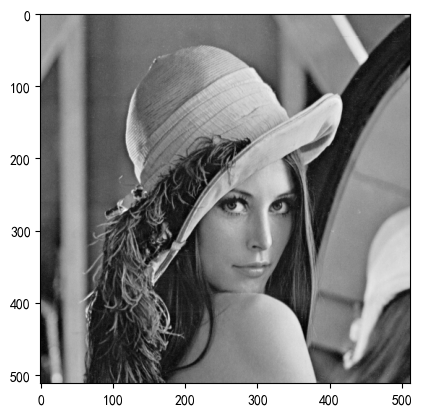

In [23]:
img = cv2.imread('lenna.png')
h,w = img.shape[:2]
img_gray = np.zeros([h,w], img.dtype)

# 使用B*0.11 + G*0.59 + R*0.3的公式进行灰度化
for i in range(h):
    for j in range(w):
        img_gray[i,j] = img[i,j][0] * 0.11 + img[i,j][1] * 0.59 + img[i,j][2] * 0.3
        
plt.imshow(img_gray, cmap='gray')

## 高斯滤波

[[129.26931582 144.67380859 144.61713788 ... 149.81447136 137.19028609
  104.7158374 ]
 [144.67404429 161.9142552  161.85083117 ... 167.66751899 153.53893846
  117.19458405]
 [144.7122288  161.95698999 161.89354923 ... 167.71177227 153.57946272
  117.22551577]
 ...
 [ 37.90305191  43.17517572  48.49075808 ... 102.83024044 100.40991122
   88.44905668]
 [ 38.30930462  43.99853906  52.00498459 ... 102.88304672 104.52700451
   95.23211912]
 [ 34.31458259  39.44864452  46.90210201 ...  91.91498918  93.86283567
   85.89087674]]


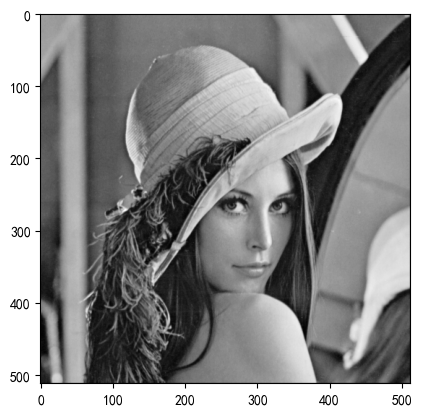

In [42]:
sigma = 0.5
dim = 5
Gaussian_filter = np.zeros([dim,dim])

# 高斯卷积核中的(x,y)为节点相对于中心像素的位置
tmp = [i-dim//2 for i in range(dim)]
n1 = 1/(2*math.pi*sigma**2)
n2 = -1/(2*sigma**2)
for i in range(dim):
    for j in range(dim):
        Gaussian_filter[i,j] = n1*math.exp(n2*(tmp[i]**2+tmp[j]**2))
# 归一化
Gaussian_filter = Gaussian_filter / Gaussian_filter.sum()
# print(Gaussian_filter)

tmp = dim//2
dx,dy = img_gray.shape
img_new = np.zeros([dx,dy])
img_pad = np.pad(img_gray, ((tmp,tmp),(tmp,tmp)), 'constant')
# print(img_pad)
for i in range(dx):
    for j in range(dy):
        # 注意矩阵乘要有np.sum()
        img_new[i,j] = np.sum(img_pad[i:i+dim,j:j+dim] * Gaussian_filter)
print(img_new)
# 图片img_new为浮点型，需要进行强制类型转换
plt.imshow(img_new.astype(np.uint8), cmap='gray')

## 边缘检测

[[-1.00000104e+00 -1.31673569e+01  3.11523627e+02 ...  1.39296150e+01
   4.20799834e+00  9.06544565e-01]
 [-7.64030393e-02 -1.00602504e+00  2.38013271e+01 ...  1.06426381e+00
   3.21503527e-01  6.92626876e-02]
 [-1.85827035e-04 -2.42077978e-03  5.61096808e-02 ...  1.88083165e-03
   5.18803030e-04  1.05015250e-04]
 ...
 [ 3.74521388e-02  5.88769486e-02 -3.83061716e-01 ... -3.14652674e+00
   5.17550672e-01  6.66487056e-02]
 [ 6.39046560e-02  2.49773396e-01  3.44418058e-01 ...  3.04231374e+00
  -7.44040935e-01 -2.89180801e-02]
 [ 9.81458445e-01  4.58729277e+00  9.84837103e+00 ...  3.60101602e+01
  -2.06693753e+01 -1.00937055e+00]]


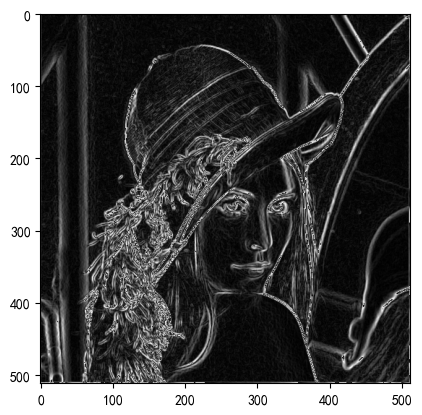

In [52]:
# Sobel算子
sobel_x = [[-1, 0, 1],
           [-2, 0, 2],
           [-1, 0, 1]]

sobel_y = [[ 1, 2, 1],
           [ 0, 0, 0],
           [-1,-2,-1]]

sx,sy = img_new.shape

img_sobel_x = np.zeros(img_new.shape)
img_sobel_y = np.zeros(img_new.shape)
img_sobel_all = np.zeros(img_new.shape)

img_spad = np.pad(img_new, ((1,1),(1,1)), 'constant')

for i in range(sx):
    for j in range(sy):
        img_sobel_x[i,j] = np.sum(img_spad[i:i+3,j:j+3] * sobel_x)
        img_sobel_y[i,j] = np.sum(img_spad[i:i+3,j:j+3] * sobel_y)
        img_sobel_all[i,j] = np.sqrt(img_sobel_x[i, j]**2 + img_sobel_y[i, j]**2)
        
# print(img_sobel_all)

img_sobel_x[img_sobel_x==0] = 0.00000001
angle = img_sobel_y/img_sobel_x

print(angel)

plt.imshow(img_sobel_all.astype(np.uint8), cmap='gray')

## 非极大值抑制

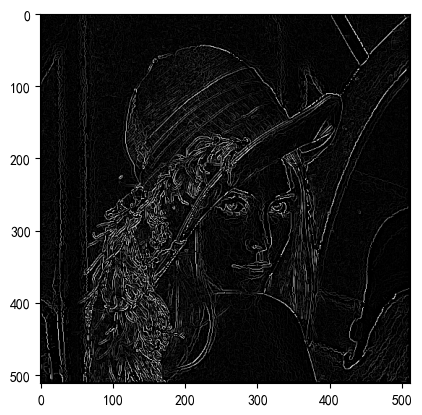

In [55]:
yx,yy = img_sobel_all.shape
img_yizhi = np.zeros([yx,yy], img_sobel_all.dtype)
for i in range(1, yx - 1):
    for j in range(1, yy - 1):
        flag = True  # 在8邻域内是否要留下
        temp = img_sobel_all[i-1:i+2, j-1:j+2]  # 梯度幅值的8邻域矩阵
        if angle[i, j] <= -1:  # 使用线性插值法判断抑制与否
            num_1 = (temp[0, 1] - temp[0, 0]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 1] - temp[2, 2]) / angle[i, j] + temp[2, 1]
            if not (img_sobel_all[i, j] > num_1 and img_sobel_all[i, j] > num_2):
                flag = False
        elif angle[i, j] >= 1:
            num_1 = (temp[0, 2] - temp[0, 1]) / angle[i, j] + temp[0, 1]
            num_2 = (temp[2, 0] - temp[2, 1]) / angle[i, j] + temp[2, 1]
            if not (img_sobel_all[i, j] > num_1 and img_sobel_all[i, j] > num_2):
                flag = False
        elif angle[i, j] > 0:
            num_1 = (temp[0, 2] - temp[1, 2]) * angle[i, j] + temp[1, 2]
            num_2 = (temp[2, 0] - temp[1, 0]) * angle[i, j] + temp[1, 0]
            if not (img_sobel_all[i, j] > num_1 and img_sobel_all[i, j] > num_2):
                flag = False
        elif angle[i, j] < 0:
            num_1 = (temp[1, 0] - temp[0, 0]) * angle[i, j] + temp[1, 0]
            num_2 = (temp[1, 2] - temp[2, 2]) * angle[i, j] + temp[1, 2]
            if not (img_sobel_all[i, j] > num_1 and img_sobel_all[i, j] > num_2):
                flag = False
        if flag:
            img_yizhi[i, j] = img_sobel_all[i, j]
            
plt.imshow(img_yizhi.astype(np.uint8), cmap='gray')          

## 双阈值检测

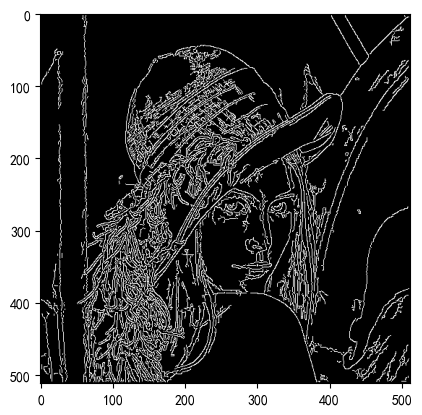

In [56]:
    lower_boundary = img_sobel_all.mean() * 0.5
    high_boundary = lower_boundary * 3
    zhan = []
    for i in range(1, img_yizhi.shape[0]-1):
        for j in range(1, img_yizhi.shape[1]-1):
            if img_yizhi[i, j] >= high_boundary:  # 取，一定是边的点
                img_yizhi[i, j] = 255
                zhan.append([i, j])
            elif img_yizhi[i, j] <= lower_boundary:  # 舍
                img_yizhi[i, j] = 0
 
    while not len(zhan) == 0:
        temp_1, temp_2 = zhan.pop()  # 出栈
        a = img_yizhi[temp_1-1:temp_1+2, temp_2-1:temp_2+2]
        if (a[0, 0] < high_boundary) and (a[0, 0] > lower_boundary):
            img_yizhi[temp_1-1, temp_2-1] = 255  # 这个像素点标记为边缘
            zhan.append([temp_1-1, temp_2-1])  # 进栈
        if (a[0, 1] < high_boundary) and (a[0, 1] > lower_boundary):
            img_yizhi[temp_1 - 1, temp_2] = 255
            zhan.append([temp_1 - 1, temp_2])
        if (a[0, 2] < high_boundary) and (a[0, 2] > lower_boundary):
            img_yizhi[temp_1 - 1, temp_2 + 1] = 255
            zhan.append([temp_1 - 1, temp_2 + 1])
        if (a[1, 0] < high_boundary) and (a[1, 0] > lower_boundary):
            img_yizhi[temp_1, temp_2 - 1] = 255
            zhan.append([temp_1, temp_2 - 1])
        if (a[1, 2] < high_boundary) and (a[1, 2] > lower_boundary):
            img_yizhi[temp_1, temp_2 + 1] = 255
            zhan.append([temp_1, temp_2 + 1])
        if (a[2, 0] < high_boundary) and (a[2, 0] > lower_boundary):
            img_yizhi[temp_1 + 1, temp_2 - 1] = 255
            zhan.append([temp_1 + 1, temp_2 - 1])
        if (a[2, 1] < high_boundary) and (a[2, 1] > lower_boundary):
            img_yizhi[temp_1 + 1, temp_2] = 255
            zhan.append([temp_1 + 1, temp_2])
        if (a[2, 2] < high_boundary) and (a[2, 2] > lower_boundary):
            img_yizhi[temp_1 + 1, temp_2 + 1] = 255
            zhan.append([temp_1 + 1, temp_2 + 1])
 
    for i in range(img_yizhi.shape[0]):
        for j in range(img_yizhi.shape[1]):
            if img_yizhi[i, j] != 0 and img_yizhi[i, j] != 255:
                img_yizhi[i, j] = 0
 
    # 绘图
    plt.imshow(img_yizhi.astype(np.uint8), cmap='gray')

# 2.实现透视变换

(960, 540, 3)
warpMatrix:
[[ 8.92263779e-01  3.76733596e-01 -2.41585375e+02]
 [-4.08140258e-01  9.44205073e-01 -5.80899328e+01]
 [-8.53836442e-05  5.16464182e-05  1.00000000e+00]]


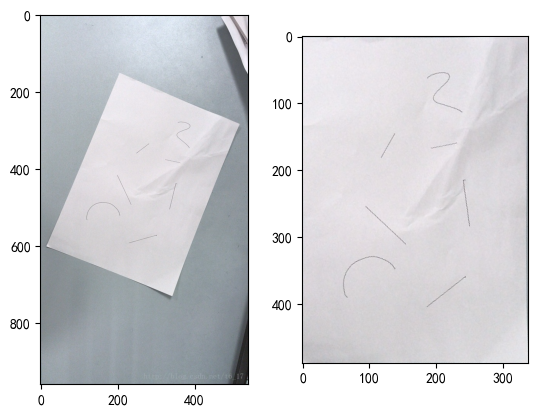

In [57]:
import cv2
import numpy as np

img = cv2.imread('photo1.jpg')

result3 = img.copy()

'''
注意这里src和dst的输入并不是图像，而是图像对应的顶点坐标。
'''
src = np.float32([[207, 151], [517, 285], [17, 601], [343, 731]])
dst = np.float32([[0, 0], [337, 0], [0, 488], [337, 488]])
print(img.shape)
# 生成透视变换矩阵；进行透视变换
m = cv2.getPerspectiveTransform(src, dst)
print("warpMatrix:")
print(m)
result = cv2.warpPerspective(result3, m, (337, 488))

plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(result, cmap='gray')